In [17]:
import tensorcircuit as tc
import tensorflow as tf
import networkx as nx

K = tc.set_backend("tensorflow")

nlayers = 3  # the number of layers
ncircuits = 2  # the number of circuits with different initial parameters

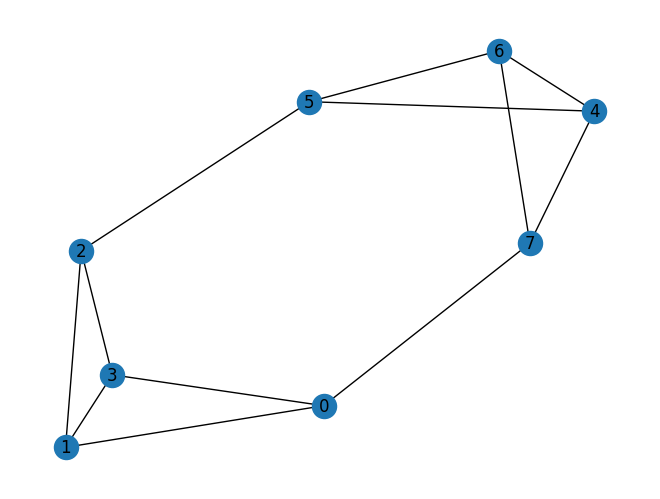

In [18]:
# def dict2graph(d):
#     g = nx.to_networkx_graph(d)
#     for e in g.edges:
#         if not g[e[0]][e[1]].get("weight"):
#             g[e[0]][e[1]]["weight"] = 1.0
#     nx.draw(g, with_labels=True)
#     return g


# # a graph instance
# # each node is connected to three nodes
# # for example, node 0 is connected to nodes 1,7,3
# example_graph_dict = {
#     0: {1: {"weight": 1.0}, 3: {"weight": 1.0}},
#     1: {0: {"weight": 1.0}, 2: {"weight": 1.0}},
#     2: {1: {"weight": 1.0}, 3: {"weight": 1.0}, 4: {"weight": 1.0}},
#     3: {0: {"weight": 1.0}, 2: {"weight": 1.0}, 4: {"weight": 1.0}},
#     4: {2: {"weight": 1.0}, 3: {"weight": 1.0}},
# }

# example_graph = dict2graph(example_graph_dict)

def dict2graph(d):
    g = nx.to_networkx_graph(d)
    for e in g.edges:
        if not g[e[0]][e[1]].get("weight"):
            g[e[0]][e[1]]["weight"] = 1.0
    nx.draw(g, with_labels=True)
    return g


# a graph instance
# each node is connected to three nodes
# for example, node 0 is connected to nodes 1,7,3
example_graph_dict = {
    0: {1: {"weight": 1.0}, 7: {"weight": 1.0}, 3: {"weight": 1.0}},
    1: {0: {"weight": 1.0}, 2: {"weight": 1.0}, 3: {"weight": 1.0}},
    2: {1: {"weight": 1.0}, 3: {"weight": 1.0}, 5: {"weight": 1.0}},
    4: {7: {"weight": 1.0}, 6: {"weight": 1.0}, 5: {"weight": 1.0}},
    7: {4: {"weight": 1.0}, 6: {"weight": 1.0}, 0: {"weight": 1.0}},
    3: {1: {"weight": 1.0}, 2: {"weight": 1.0}, 0: {"weight": 1.0}},
    6: {7: {"weight": 1.0}, 4: {"weight": 1.0}, 5: {"weight": 1.0}},
    5: {6: {"weight": 1.0}, 4: {"weight": 1.0}, 2: {"weight": 1.0}},
}

example_graph = dict2graph(example_graph_dict)

In [19]:
def QAOAansatz(params, g=example_graph):
    n = len(g.nodes)  # the number of nodes
    c = tc.Circuit(n)
    for i in range(n):
        c.H(i)
    # PQC
    for j in range(nlayers):
        # U_j
        for e in g.edges:
            c.exp1(
                e[0],
                e[1],
                unitary=tc.gates._zz_matrix,
                theta=g[e[0]][e[1]].get("weight", 1.0) * params[2 * j],
            )
        # V_j
        for i in range(n):
            c.rx(i, theta=params[2 * j + 1])

    # calculate the loss function
    loss = 0.0
    for e in g.edges:
        loss += c.expectation_ps(z=[e[0], e[1]])

    return K.real(loss)

In [20]:
# use vvag to get the losses and gradients with different random circuit instances
QAOA_vvag = K.jit(tc.backend.vvag(QAOAansatz, argnums=0, vectorized_argnums=0))

In [24]:
params = K.implicit_randn(
    shape=[ncircuits, 2 * nlayers], stddev=0.1
)  # initial parameters
opt = K.optimizer( tf.keras.optimizers.legacy.Adam(1e-2))

for i in range(100):
    loss, grads = QAOA_vvag(params, example_graph)
    print(K.numpy(loss))
    params = opt.update(grads, params)  # gradient descent

[0.0379655  0.12443611]
[-0.13020703 -0.01187936]
[-0.27582037 -0.10494626]
[-0.4126733  -0.19884732]
[-0.5492018  -0.30047107]
[-0.6877516  -0.40840316]
[-0.82822335 -0.52166504]
[-0.9703346  -0.63943934]
[-1.1136746 -0.760973 ]
[-1.2577317  -0.88551265]
[-1.4019203 -1.0122957]
[-1.5455785 -1.1405241]
[-1.6880085 -1.2693808]
[-1.8284357 -1.3979969]
[-1.9661036 -1.5254871]
[-2.1002047 -1.6509614]
[-2.2299418 -1.7735074]
[-2.3545444 -1.8922312]
[-2.4732614 -2.0062537]
[-2.5853856 -2.1147447]
[-2.6927698 -2.2222614]
[-2.795937 -2.328385]
[-2.8942652 -2.433274 ]
[-2.9871294 -2.5356805]
[-3.073924 -2.636042]
[-3.1540227 -2.7331433]
[-3.231273  -2.8268309]
[-3.3038173 -2.9168477]
[-3.369969  -3.0015378]
[-3.433199  -3.0825284]
[-3.4899378 -3.1573386]
[-3.5422373 -3.2226882]
[-3.5895615 -3.2836235]
[-3.631668  -3.3409052]
[-3.6683047 -3.3929002]
[-3.6992788 -3.441318 ]
[-3.7237706 -3.4833846]
[-3.7454872 -3.5221767]
[-3.76866  -3.559724]
[-3.7819781 -3.5935998]
[-3.8043976 -3.624661 ]
[-3.81